# <center> Main: Group 10

In order to find the relationship between L(greyscale input) and A/B(layers about colors), we tried SVM, XGB and GBM.    

## 1. Model1: SVM

### Step1: Import packages

In [ ]:
import cv2 
import itertools
import numpy as np
from scipy.cluster.vq import kmeans,vq
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.cluster import KMeans
import matplotlib as plt
from skimage import color
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
import matplotlib.pyplot as plt
import sys
sys.path.append("./ImageColorization-master/colorizer/gco_python/")
import pygco

### Step2: Prepare for image processing

Here, we write some functions about feature extraction and creating color map based on training data set.

In [7]:
# from skimage import color 
def load_image(path):
    '''
    Read in a file and separate into L*a*b* channels
    '''
    #read in original image
    img = cv2.imread(path) 
    #convert to L*a*b* space and split into channels
    l, a, b = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2LAB))
    return l, a, b

# K-means Color Space and Centroids
def quantize_kmeans(a, b,ncolors, npics):
    lengthab = len(a) / npics
    
#     w,h = np.shape(a)
        
    # reshape matrix
    pixel = np.reshape((cv2.merge((a,b))),(len(a),2)).astype(float)
    
    # quantization
    kmeans = KMeans(n_clusters=ncolors) 
    label=kmeans.fit(pixel)
    return label.labels_.reshape(int(np.sqrt(int(lengthab))),int(np.sqrt(int(lengthab))),int(npics))

# def label_to_color_map_fun(a,b,ncolors):
#     w,h = np.shape(a)
#     pixel = np.reshape((cv2.merge((a,b))),(w * h),2).astype(float)
#     centroids,_ = kmeans(pixel,ncolors)

#     color_to_label_map = {c:i for i,c in enumerate([tuple(i) for i in centroids])}
#     label_to_color_map = dict(zip(color_to_label_map.values(),color_to_label_map.keys()))
#     return label_to_color_map

def label_to_color_map_fun(a,b,ncolors):
#     w,h = np.shape(a)
    pixel = np.reshape((cv2.merge((a,b))),(len(a),2)).astype(float)
    centroids,_ = kmeans(pixel,ncolors)

    color_to_label_map = {c:i for i,c in enumerate([tuple(i) for i in centroids])}
    label_to_color_map = dict(zip(color_to_label_map.values(),color_to_label_map.keys()))
    return label_to_color_map

def feature_surf(img, pos):
    '''
    Gets the SURF descriptor of img at pos = (x,y).
    Assume img is a single channel image.
    '''
    octave2 = cv2.GaussianBlur(img, (0, 0), 1)
    octave3 = cv2.GaussianBlur(img, (0, 0), 2)
    kp = cv2.KeyPoint(pos[0], pos[1], SURF_WINDOW)
    surf = cv2.xfeatures2d.SURF_create()
    _, des1 = surf.compute(img, [kp])
    _, des2 = surf.compute(octave2, [kp])
    _, des3 = surf.compute(octave3, [kp])
    return np.concatenate((des1[0], des2[0], des3[0]))

def feature_dft(img, pos):
    xlim = (max(pos[0] - windowSize,0), min(pos[0] + windowSize,img.shape[1]))
    ylim = (max(pos[1] - windowSize,0), min(pos[1] + windowSize,img.shape[0]))
    patch = img[ylim[0]:ylim[1],xlim[0]:xlim[1]]
        
    l = (2*windowSize + 1)**2
    
    #return all zeros for now if we're at the edge
    if patch.shape[0]*patch.shape[1] != l:
        return np.zeros(l)
    return np.abs(np.fft(patch.flatten()))


def feature_position(img, pos):
    m,n = img.shape
    x_pos = pos[0]/n
    y_pos = pos[1]/m
    
    return np.array([x_pos, y_pos])
            

def get_features(img, pos):
    intensity = np.array([img[pos[1], pos[0]]])
    #position = feature_position(img, pos)
    meanvar = np.array([getMean(img, pos), getVariance(img, pos)])
    feat = np.concatenate((meanvar, feature_surf(img, pos), feature_dft(img, pos)))
    return feat


def getMean(img, pos):
    ''' 
    Returns mean value over a windowed region around (x,y)
    '''
     
    xlim = (max(pos[0] - windowSize,0), min(pos[0] + windowSize,img.shape[1]))
    ylim = (max(pos[1] - windowSize,0), min(pos[1] + windowSize,img.shape[0]))
    return np.mean(img[ylim[0]:ylim[1],xlim[0]:xlim[1]])

        
def getVariance(img, pos):
    
    xlim = (max(pos[0] - windowSize,0), min(pos[0] + windowSize,img.shape[1]))
    ylim = (max(pos[1] - windowSize,0), min(pos[1] + windowSize,img.shape[0]))
    
    return np.var(img[ylim[0]:ylim[1],xlim[0]:xlim[1]])/1000

# add
def get_edges(img, blur_width=3):
        img_blurred = cv2.GaussianBlur(img, (0, 0), blur_width)
        vh = cv2.Sobel(img_blurred, -1, 1, 0)
        vv = cv2.Sobel(img_blurred, -1, 0, 1)

        #vh = vh/np.max(vh)
        #vv = vv/np.max(vv)
        
        #v = np.sqrt(vv**2 + vh**2)

        v = 0.5*vv + 0.5*vh
#        print('max pre-normalize: %f'%np.amax(v))
        #v = v/np.amax(v)
        return v

### Step3: Prepare for building model

In [ ]:
def train_svm_new(files,ntrain,ncolors,prob,gamma,cost,npca):
    
    #dimensions of image
    l,a,b = load_image(files[0])
    m,n = l.shape 
    features = []
    classes = []
    numTrainingExamples = 0
    colors_present = []
    svm = [SVC(probability=prob, gamma=gamma, C=cost) for i in range(ncolors)]
    pca = PCA(npca)
    
    scaler = preprocessing.MinMaxScaler() 
    npics = len(files)
    kmap_a = np.array([])
    kmap_b = np.array([])
    for f in files:

        _,a,b = load_image(f)
        kmap_a = np.concatenate([kmap_a, a.flatten()])
        kmap_b = np.concatenate([kmap_b, b.flatten()])

    label=quantize_kmeans(kmap_a, kmap_b, ncolors, npics)  #get labels for files 
    
    for ind, f in enumerate(files):
        l,a,b = load_image(f)  
#         a,b = quantize_kmeans(a,b, ncolors, 1)
        
        for i in range(ntrain):
        #choose random pixel in training image
            x = int(np.random.uniform(n))
            y = int(np.random.uniform(m))
        
            features.append(get_features(l, (x,y)))
            classes.append(label[x,y,ind])
            numTrainingExamples = numTrainingExamples + 1
        
    # normalize columns
    features =np.array(features)
    classes = np.array(classes)
        
       
    # reduce dimensionality
    #features = pca.fit_transform(features)
    
    for i in range(ncolors):
        if len(np.where(classes==i)[0])>0:
            curr_class = (classes==i).astype(np.int32)
            colors_present.append(i)
            svm[i].fit(features,(classes==i).astype(np.int32))
            
    return colors_present,svm

### Step4: Train Model

In [ ]:
train_dir = ['./data/' + str(num).zfill(4) + '.jpg' for num in range(1,6)]
train_dir

ncolors = 16
ntrain = 8000
# (l, a, b) = load_image(img)
prob = False
npca = 635
gamma = 0.1
cost = 5.0
colors_present,svm = train_svm_new(train_dir,
                           ntrain = ntrain,
                           ncolors = ncolors,
                           prob = prob,
                           gamma = gamma,
                           cost = cost,
                           npca = npca)

In [ ]:
label_to_color_map = label_to_color_map_fun(a,b,ncolors)
label_to_color_map

### Step5: Graph Cut Algorithm

In [ ]:
def graphcut(colors_present, label_to_color_map, label_costs, g, l=100):
    
    num_classes = len(colors_present)

    #calculate pariwise potiential costs (distance between color classes)
    pairwise_costs = np.zeros((num_classes, num_classes))
    for ii in range(num_classes):
        for jj in range(num_classes):
            c1 = np.array(label_to_color_map[ii])
            c2 = np.array(label_to_color_map[jj])
            pairwise_costs[ii,jj] = np.linalg.norm(c1-c2)

    label_costs_int32 = (100*label_costs).astype('int32')
    pairwise_costs_int32 = (l*pairwise_costs).astype('int32')
    vv_int32 = g.astype('int32')
    vh_int32 = g.astype('int32')

    #vv_int32 = (1/np.clip(self.g,0.00001,10000)).astype('int32')
    #vh_int32 = (1/np.clip(self.g,0.00001,10000)).astype('int32')

    #perform graphcut optimization
    new_labels = pygco.cut_simple_vh(label_costs_int32,
                                     pairwise_costs_int32,
                                     vv_int32, vh_int32,
                                     n_iter=10, algorithm='swap') 

    #new_labels = pygco.cut_simple(label_costs_int32, pairwise_costs_int32, algorithm='swap')

    return new_labels

### Step6: Colorize

In [ ]:
def colorize(colors_present,label_to_color_map, img, svm, skip=4, SAVE_OUTPUTS = False):
    '''
    -- colorizes a grayscale image, using the set of SVMs defined by train().

    Returns:
    -- ndarray(m,n,3): a mxn pixel RGB image
    ''' 
    scaler = preprocessing.MinMaxScaler()   
    m,n = img.shape

    num_classified = 0
    _,raw_output_a,raw_output_b = cv2.split(cv2.cvtColor(cv2.merge((img, img, img)), 
                                                         cv2.COLOR_RGB2LAB))

#     raw_output_a,_,raw_output_b = cv2.split(cv2.cvtColor(cv2.merge((img, img, img)), 
#                                                          cv2.COLOR_RGB2HLS))
#     _,raw_output_a,raw_output_b = cv2.split(cv2.cvtColor(cv2.merge((img, img, img)), cv.CV_RGB2Lab)) 
    #default a and b for a grayscale image

    output_a = np.zeros(raw_output_a.shape)
    output_b = np.zeros(raw_output_b.shape)

    num_classes = len(colors_present)
    label_costs = np.zeros((m,n,num_classes))

    g = np.zeros(raw_output_a.shape)

    count=0
    for x in np.arange(0,n,skip):
        for y in np.arange(0,m,skip):
            
            feat = get_features(img, (x,y)).reshape(1,-1)
#             feat = scaler.fit_transform(get_features(img, (x,y)).reshape(-1,1).reshape(1,-1))
#             feat = scaler.fit_transform(np.array(tmp).reshape(-1,1),y= np.array([0,1]))
#             print(len(feat))

            #print "Size, Pre-PCA"
            #print np.shape(feat)
#             pca = PCA(npca)
#             feat = pca.fit_transform(feat)
            #print "size, Post-PCA"
            #print np.shape(feat)

            #sys.stdout.write('\rcolorizing: %3.3f%%'%(np.min([100, 100*count*skip**2/(m*n)])))
            #sys.stdout.flush()
            count += 1

            # Hard-but-correct way to get g
            # self.g[y-int(skip/2):y+int(skip/2)+1,x-int(skip/2):x+int(skip/2)+1] = self.color_variation(feat)

            #get margins to estimate confidence for each class
            for i in range(num_classes):
                cost = -1*svm[colors_present[i]].decision_function(feat)[0]
                label_costs[y-int(skip/2):y+int(skip/2)+1,x-int(skip/2):x+int(skip/2)+1,i] = cost
    #edges = self.get_edges(img)
    #self.g = np.sqrt(edges[0]**2 + edges[1]**2)
    g = get_edges(img)
    #self.g = np.log10(self.g)

    if SAVE_OUTPUTS:
        #dump to pickle
        print('saving to dump.dat')
        fid = open('dump.dat', 'wb') 
        pickle.dump({'S': label_costs, 'g': g, 'cmap': label_to_color_map,
                     'colors': colors_present}, fid)
        fid.close()

    # postprocess using graphcut optimization 
#     output_labels = graphcut(label_costs, l=graphcut_lambda)
    output_labels = graphcut(colors_present, label_to_color_map, label_costs, g, l=100)
    

    
    for i in range(m):
        for j in range(n):

            a,b = label_to_color_map[colors_present[output_labels[i,j]]]

            output_a[i,j] = a
            output_b[i,j] = b
            
    output_img = cv2.cvtColor(cv2.merge(( img,np.uint8(output_a), np.uint8(output_b))), cv2.COLOR_LAB2RGB)

    return output_img, g, output_labels

### Step7: Show the test image

In [ ]:
# img_file = cv2.imread(img)
# img_file = load_image(img)[0]
# get_edges(img_file)
# img_test = './Train/test.jpg'
img_test = './data/0003.jpg'
# l a b
img_test_file = load_image(img_test)
# img_test_file = cv2.imread(img_test) 
color_tmp = colorize(colors_present,label_to_color_map, img = img_test_file[0], svm = svm, skip=16)

In [ ]:
plt.imshow(color_tmp[0])
plt.show()
plt.imsave('color_tmp.jpg',color_tmp[0])
# plt.imshow(load_image_gray(img_test)[0])
# plt.show()

According to the result, we could see that svm did not perform well on cartoon images. 

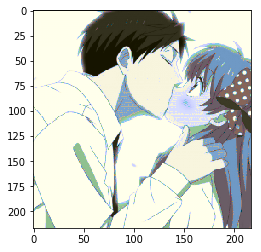

In [15]:
import matplotlib.pyplot as plt
import cv2
img_test = 'C:/Users/rolco/Desktop/car.png'
img_test_file = cv2.imread(img_test) 
plt.imshow(img_test_file)

## 2.Model2: Xgboost

Since svm did not perform well on predicting the color labels of a and b, we tried to built xgboost to find the relationship between grey layer and color labels. What's more, we extracted more features(hog and daisy) rather than L only from grey layer in this model.  

### Step1: Import Packages

In [ ]:
import cv2 
import itertools
import numpy as np
from scipy.cluster.vq import kmeans,vq
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.cluster import KMeans
import operator
from functools import reduce
import xgboost as xgb
import matplotlib.pyplot as plt
import os
from PIL import Image
from skimage.feature import hog, daisy

### Step2: Prepare for image processing

In [ ]:
# from skimage import color 
def load_image(path):
    '''
    Read in a file and separate into L*a*b* channels
    '''
    #read in original image
    img = cv2.imread(path) 
    l, a, b = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2LAB))
#     a, l, b = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2HLS))


    return l, a, b

def quantize_kmeans(a, b,ncolors, npics):
    lengthab = len(a) / npics
            
    # reshape matrix
    pixel = np.reshape((cv2.merge((a,b))),(len(a),2)).astype(float)
    
    # quantization
    kmeans = KMeans(n_clusters=ncolors) 
    label=kmeans.fit(pixel)
    return label.labels_

def label_to_color_map_fun(a,b,ncolors):
    w,h = np.shape(a)
    pixel = np.reshape((cv2.merge((a,b))),(w * h,2)).astype(float)
    centroids,_ = kmeans(pixel,ncolors)
    color_to_label_map = {c:i for i,c in enumerate([tuple(i) for i in centroids])}
    label_to_color_map = dict(zip(color_to_label_map.values(),color_to_label_map.keys()))
    return label_to_color_map

def get_feature(file):
    test_color = Image.open(file,'r')
    test_color = test_color.convert('L') #makes it greyscale
    test_gray = np.asarray(test_color.getdata(),dtype=np.float64).reshape((test_color.size[1],test_color.size[0]))
    test_gray = np.asarray(test_gray,dtype=np.uint8) #if values still in range 0-255! 
    test_gray = Image.fromarray(test_gray,mode='L')
    
    # l(256,256)
    l, a, b = load_image(file)
    w,h = np.shape(a)
    # hog(256,256)
    fd, hog_image = hog(test_gray, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualise=True)
    # daisy(256,256,3)
    descs, descs_img = daisy(test_gray, step=180, radius=58, rings=2, histograms=6,
                             orientations=8, visualize=True)
    feature = np.zeros((256*256,5))
    feature[:,0] = hog_image.reshape(1,256*256)[0]
    feature[:,1] = descs_img[:,:,0].reshape(1,256*256)[0]
    feature[:,2] = descs_img[:,:,1].reshape(1,256*256)[0]
    feature[:,3] = descs_img[:,:,2].reshape(1,256*256)[0]
    feature[:,4] = l.reshape(1,256*256)[0]
    
    return(feature)


### Step 3: Prepare for model

In [ ]:
def train_xgb(files,ncolors,num_class, npics):
    
    kmap_a=np.array([])
    kmap_b=np.array([])
    for f in files:
        _,a,b = load_image(f)
        kmap_a = np.concatenate([kmap_a, a.flatten()])
        kmap_b = np.concatenate([kmap_b, b.flatten()])
    w,h = np.shape(a)
    label=quantize_kmeans(kmap_a, kmap_b, ncolors, npics)
    
    pixel=[]
    for f in files:
        l, a, b = load_image(f)
        this_pixel = l.reshape(1,w*h).tolist()
        pixel.append(this_pixel[0])

    pixel = reduce(operator.add, pixel)

    pixel_mat = np.array(pixel).reshape(npics*w*h,1)

    dtrain = xgb.DMatrix(pixel_mat, label=label)
    param = {'max_depth':10, 'eta':0.1, 'silent':1, 'objective':'multi:softmax', 'num_class':num_class}
    num_round = 10
    print('Begin xgb training')
    bst = xgb.train(param, dtrain, num_round)
    return bst

def train_xgb_fea(files,ncolors,num_class, npics):
    
    kmap_a=np.array([])
    kmap_b=np.array([])
    

    for f in files:
        _,a,b = load_image(f)
        kmap_a = np.concatenate([kmap_a, a.flatten()])
        kmap_b = np.concatenate([kmap_b, b.flatten()])

    label=quantize_kmeans(kmap_a, kmap_b, ncolors, npics)
    w,h = np.shape(a)
        
    pixel_feature = np.zeros(shape=(w*h*npics,1))
    

    
    for ind,f in enumerate(files):
        feature = get_feature(f)
        pixel_feature[(w*h*ind):(w*h*(ind+1)),:] = feature

#     pixel_mat = np.array(pixel).reshape(npics*256*256,1)

    dtrain = xgb.DMatrix(pixel_feature, label=label)
    param = {'max_depth':10, 'eta':0.1, 'silent':1, 'objective':'multi:softmax', 'num_class':num_class}
    num_round = 10
    print('Begin xgb training')
    bst = xgb.train(param, dtrain, num_round)
    return bst

def test_xgb_fea(file,xgb_model):
        
    pixel_feature = get_feature(file)

    dtest=xgb.DMatrix(pixel_feature)
    preds = xgb_fit.predict(dtest)

    return preds

### Step4: Train Model

In [ ]:
#load images
folder_dir = './girl/'
train_dir = []

for filename in os.listdir(folder_dir):
    if filename.startswith('.') or \
    filename.startswith('predict') or \
    filename.startswith('gray'): 
        continue
    train_dir.append(folder_dir + filename)

# train_dir = ['WechatIMG1667.jpeg']

In [ ]:
ncolors = 16
kmap_a=np.array([])
kmap_b=np.array([])
for f in train_dir:
    _,a,b = load_image(f)
    kmap_a = np.concatenate([kmap_a, a.flatten()])
    kmap_b = np.concatenate([kmap_b, b.flatten()])
h,w = np.shape(a)

In [ ]:
npics = len(train_dir) # number of train image
kmap_a = kmap_a.reshape(npics*w*h,1)
kmap_b = kmap_b.reshape(npics*w*h,1)
label_to_color_map = label_to_color_map_fun(kmap_a,kmap_b,ncolors)
print(len(label_to_color_map))
ncolors = len(label_to_color_map) # update ncolors

In [ ]:
xgb_fit = train_xgb_fea(train_dir,ncolors,ncolors,npics)

### Step5: Colorize new test image

In [ ]:
test_img = './girl/gray/WechatIMG1286_gray.jpg'
preds = test_xgb_fea(test_img, xgb_fit)

In [ ]:
def pred2color(test_img,preds,label_to_color_map,ncolors=16, saveimg = False, savename = 'test.jpg'):
    l_test, a_test, b_test = load_image(test_img)
    preds = preds.reshape(h,w)
    print(w,h)
    colors_present = [i for i in range(ncolors)]
    output_a = np.zeros((h,w))
    output_b = np.zeros((h,w))
    output_l = l_test.reshape((h,w))
    for i in range(h):
        for j in range(w):
            a,b = label_to_color_map[colors_present[int(preds[i,j])]]
            output_a[i,j] = a
            output_b[i,j] = b
    print(output_a.shape,output_b.shape,output_l.shape)
    output_img = cv2.cvtColor(cv2.merge(( np.uint8(output_l), np.uint8(output_a), np.uint8(output_b))),
                              cv2.COLOR_LAB2RGB)
    if saveimg == True:
        plt.imsave('./girl/predict/' + savename,output_img)    
    return(output_img)

In [ ]:
output_img = pred2color(test_img,preds,label_to_color_map,ncolors=ncolors,
                        saveimg = False, savename = 'wenzhu.jpg')
plt.imshow(output_img)
# cv2.imwrite('savename.jpg', output_img )
# plt.imsave('./girl/predict/output_img_gile12.jpg',output_img)

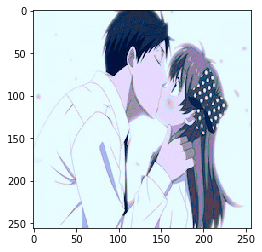

In [33]:
img_test = 'C:/Users/rolco/Desktop/result3.jpg'
img_test_file = plt.imread(img_test)
plt.imshow(img_test_file)
plt.show()

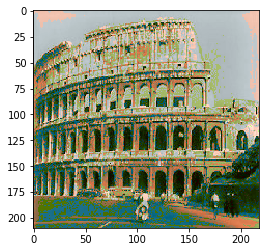

In [35]:
img_test = 'C:/Users/rolco/Desktop/ghost.png'
img_test_file = plt.imread(img_test)
plt.imshow(img_test_file)
plt.show()

Here we could see that xgboost performed well on colorizing cartoon. However, for architectures, it does not so well. So we tried to build GBM model as our next model. 

## 3.Model3: GBM

In [ ]:
import numpy as np
import pandas as pd
import skimage
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from skimage.feature import hog
from skimage.feature import daisy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

# import train_label, train_image, test_image
label999 = pd.read_csv('/Users/yuexuanhuang/Documents/GitHub/Spring2018-Project5-grp_10/output/GBM/train_label/label999.csv').iloc[:,1:]
train_color = Image.open('/Users/yuexuanhuang/Documents/GitHub/Spring2018-Project5-grp_10/data/GBM/data-ach/7.jpg','r')
label = label999
test_color = Image.open('/Users/yuexuanhuang/Documents/GitHub/Spring2018-Project5-grp_10/data/GBM/Archive/img_1.png','r')

# train model, predict, output
def colorme(train_color, train_label, test_color):

    train_color = train_color.convert('L') #makes it greyscale
    train_gray = np.asarray(train_color.getdata(),dtype=np.float64).reshape((train_color.size[1],train_color.size[0]))
    train_gray = np.asarray(train_gray,dtype=np.uint8) #if values still in range 0-255! 
    train_gray = Image.fromarray(train_gray,mode='L')
    # train_gray.save('/Users/yuexuanhuang/Desktop/Proj_5/alpha2/gray/gray%s.png'%000)
    
    test_color = test_color.convert('L') #makes it greyscale
    test_gray = np.asarray(test_color.getdata(),dtype=np.float64).reshape((test_color.size[1],test_color.size[0]))
    test_gray = np.asarray(test_gray,dtype=np.uint8) #if values still in range 0-255! 
    test_gray = Image.fromarray(test_gray,mode='L')
    # test_gray.save('/Users/yuexuanhuang/Desktop/Proj_5/alpha2/gray/gray%s.png'%001)
    
    # hog(256,256)
    fd, hog_image = hog(train_gray, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualise=True)
    
    # daisy(256,256,3)
    descs, descs_img = daisy(train_gray, step=180, radius=58, rings=2, histograms=6,
                             orientations=8, visualize=True)
    
    train = pd.DataFrame(np.matrix(np.full((65536, 5), np.inf)))
    train.columns = ['label', 'hog', 'daisy1', 'daisy2', 'daisy3']
    for i in range(5):
        if i == 0:
            collect = train_label
            for j in range(256):
                for k in range(256):
                    train.iloc[k+j*256, i] = collect.iloc[k,j]
        
        if i == 1:
            collect = np.matrix(hog_image)
            for j in range(256):
                for k in range(256):
                    train.iloc[k+j*256, i] = collect[k,j]
                    
        if i == 2:
            collect = np.matrix(descs_img[:,:,0])
            for j in range(256):
                for k in range(256):
                    train.iloc[k+j*256, i] = collect[k,j]
                    
        if i == 3:
            collect = np.matrix(descs_img[:,:,1])
            for j in range(256):
                for k in range(256):
                    train.iloc[k+j*256, i] = collect[k,j]
                    
        if i == 4:
            collect = np.matrix(descs_img[:,:,2])
            for j in range(256):
                for k in range(256):
                    train.iloc[k+j*256, i] = collect[k,j]
                    
    train_features, test_features, train_labels, test_labels = train_test_split(train.iloc[:,1:], train.iloc[:,0], test_size = 0.3, random_state = 42)
    clf = GradientBoostingClassifier()
    clf.fit(train_features, train_labels)
    # label_predict = clf.predict(test_features)
    # np.mean(label_predict == test_labels)

    # test
    # hog(256,256)
    fd, hog_image = hog(test_gray, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualise=True)
    
    # daisy(256,256,3)
    descs, descs_img = daisy(test_gray, step=180, radius=58, rings=2, histograms=6,
                             orientations=8, visualize=True)
    
    test = pd.DataFrame(np.matrix(np.full((65536, 4), np.inf)))
    test.columns = ['hog', 'daisy1', 'daisy2', 'daisy3']
    for i in range(4):
        if i == 0:
            collect = np.matrix(hog_image)
            for j in range(256):
                for k in range(256):
                    test.iloc[k+j*256, i] = collect[k,j]
                    
        if i == 1:
            collect = np.matrix(descs_img[:,:,0])
            for j in range(256):
                for k in range(256):
                    test.iloc[k+j*256, i] = collect[k,j]
                    
        if i == 2:
            collect = np.matrix(descs_img[:,:,1])
            for j in range(256):
                for k in range(256):
                    test.iloc[k+j*256, i] = collect[k,j]
                    
        if i == 3:
            collect = np.matrix(descs_img[:,:,2])
            for j in range(256):
                for k in range(256):
                    test.iloc[k+j*256, i] = collect[k,j]
    
    test_predict = clf.predict(test)
    test_label = pd.DataFrame(np.matrix(np.full((256, 256), np.inf)))
    for i in range(256):
        for j in range(256):
            test_label.iloc[j,i] = test_predict[j+i*256]
    
    return test_label

# get the test_label
t_label = colorme(train_color = train_color, train_label = label, test_color = test_color)

# import the image we need to colorize
test_color = test_color.convert('L') #makes it greyscale
test_gray = np.asarray(test_color.getdata(),dtype=np.float64).reshape((test_color.size[1],test_color.size[0]))
test_gray = np.asarray(test_gray,dtype=np.uint8) #if values still in range 0-255! 
test_gray = Image.fromarray(test_gray,mode='L')
test_gray.save('/Users/yuexuanhuang/Documents/GitHub/Spring2018-Project5-grp_10/output/GBM/gray/gray%s.png'%11)

img = cv2.imread('/Users/yuexuanhuang/Documents/GitHub/Spring2018-Project5-grp_10/data/GBM/Archive/img_1.png')
# img = cv2.resize(img, (256, 256)) 
l, a, b = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2LAB))
Lab_l = np.matrix(l)

# define colorize function
def show(standard, t_label, Lab_l):
    Lab_a = np.matrix(np.full((256, 256), np.inf))
    Lab_b = np.matrix(np.full((256, 256), np.inf))
    for i in range(256):
        for j in range(256):
            Lab_a[i,j] = standard[np.int(t_label.iloc[i,j])][0]
            Lab_b[i,j] = standard[np.int(t_label.iloc[i,j])][1]
            
    ar = np.zeros((256,256,3))
    ar[:,:,0] = Lab_l / 2.55
    ar[:,:,1] = Lab_a
    ar[:,:,2] = Lab_b
    rgb = skimage.color.lab2rgb(ar)
    return rgb

# show the colorful picture
plt.imshow(show(standard, t_label, Lab_l))

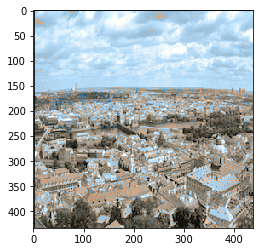

In [36]:
img_test = 'C:/Users/rolco/Desktop/arch.png'
img_test_file = plt.imread(img_test)
plt.imshow(img_test_file)
plt.show()

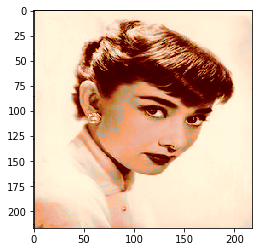

In [40]:
img_test = 'C:/Users/rolco/Desktop/color2.png'
img_test_file = plt.imread(img_test)
plt.imshow(img_test_file)
plt.show()